In [66]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import pandas as pd
import sys
import bpy
import os

sys.path.append(str(Path("..").resolve()))
from src import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
dataset=ObjaverseDataset3D()

In [83]:
dataset.statistics.sample(n=5)

,meshCount,uvCount,diffuseCount,uvScore,valid
uid,,,,,
0720eba90fba40d3bf329e7cf01654d2,2,<NA>,<NA>,<NA>,<NA>
3531334123a3485b8a31322556157c59,6,<NA>,<NA>,<NA>,<NA>
ac2eaeeccf9b4212a25c0df404551470,1,1,1,0.915316,True
3bf92701730945528ef5f5c3cb4527ab,5,<NA>,<NA>,<NA>,<NA>
2529696ab7d645c89776b88eb66cf69a,1,0,0,<NA>,False


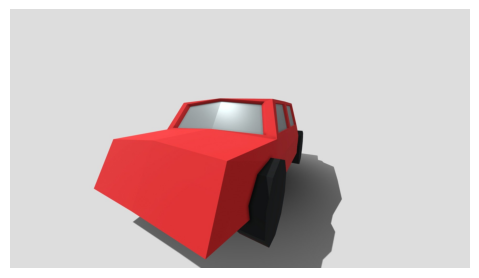

In [92]:
UID = "3bf92701730945528ef5f5c3cb4527ab"
imshow((dataset[UID]).renderings, size=6)

In [93]:
obj3d.export()

Info: Saved "scene.blend"


In [86]:
pairs = []
for obj in filter(lambda o: o.type == "MESH", bpy.data.objects):
    mesh = obj.data
    mesh_name = mesh.name
    obj_name = obj.name

    # Gather this mesh's UV layer names
    uv_layer_names = [uv.name for uv in mesh.uv_layers]
    if len(uv_layer_names) == 0:
        continue

    # Gather all materials on this mesh
    mat_slots = list(obj.material_slots)
    if len(mat_slots) == 0:
        # No materials → record one line with "<no_mesh_material>"
        continue

    # For each material slot, find diffuse images
    for slot in mat_slots:
        mat = slot.material
        mat_name = mat.name if mat else "<no_material>"
        if mat is None or not mat.use_nodes:
            # Material with no node tree → no texture
            continue

        # Inspect the node tree
        found_any_image_for_this_material = False
        for node in mat.node_tree.nodes:
            if node.type == "TEX_IMAGE":
                # Check if this node is actually feeding Base Color of a principled BSDF
                for out_socket in node.outputs:
                    # We expect node.outputs['Color'] → some link → principled_bsdf.inputs['Base Color']
                    for link in out_socket.links:
                        to_node = link.to_node

                        # Walk the chain if necessary: If the link goes into a Mix→...→Principled,
                        # we should ideally find Principled BSDF. For simplicity, we check if *any*
                        # path leads to a Principled BSDF Base Color.
                        def leads_to_base_color(node_in):
                            """
                            Returns True if node_in is a Principled BSDF that is connected to 'Base Color'.
                            If node_in is a Mix/RGB node that eventually feeds into principled, we recurse.
                            """
                            if node_in.type == "BSDF_PRINCIPLED":
                                # Check if this link is into ‘Base Color’ specifically
                                for idx_input, socket in enumerate(node_in.inputs):
                                    if socket.name == "Base Color":
                                        # If any of its links come from our chain, OK
                                        for s_link in socket.links:
                                            if s_link.from_node == node:
                                                return True
                                        # (Note: in complicated graphs, we might have to traverse further,
                                        # but in most GLTF imports it’s direct.)
                                return False
                            else:
                                # If it’s a MixRGB or other node with outputs that go to Principled, recurse
                                for out2 in node_in.outputs:
                                    for l2 in out2.links:
                                        if leads_to_base_color(l2.to_node):
                                            return True
                                return False

                        if leads_to_base_color(to_node):
                            # At this point, node.image is the diffuse image
                            img = node.image
                            if img is not None:
                                found_any_image_for_this_material = True
                                # Determine the UV map used by this TexImage node
                                uv_layer = "<implicit_uv>"
                                uv_input = node.inputs.get("Vector")
                                if uv_input is not None and len(uv_input.links) > 0:
                                    from_node = uv_input.links[0].from_node
                                    if from_node.type == "UVMAP":
                                        uv_layer = from_node.uv_map
                                    else:
                                        # If no UVMap node is inserted, Blender defaults to first UV
                                        if len(uv_layer_names) > 0:
                                            uv_layer = uv_layer_names[0]
                                        else:
                                            continue
                                else:
                                    # No link → use default “UVMap” if present
                                    if len(uv_layer_names) > 0:
                                        uv_layer = uv_layer_names[0]
                                    else:
                                        continue

                                # Save one pair per distinct image node
                                uv_draw = obj3d.draw_uv(mesh =mesh, uv_layer=uv_layer)
                                pairs.append(
                                    (
                                        mesh_name,
                                        mat_name,
                                        uv_draw,
                                        img,
                                    )
                                )

In [94]:
imshow(bpy2pil(pair[3]) for pair in pairs )

In [89]:
imshow(pair[2] for pair in pairs if pair[2])

In [90]:
[pair[1] for pair in pairs]

[]

In [95]:
pairs

[]